# **TinyVGG, BNN and Data Augmentation project**

## Resources

### Libraries

In [1]:
# Import torch
import torch
from torch import nn

# Import TorchVision domain library
import torchvision
from torchvision import transforms

# Impor torchinfo
from torchinfo import summary

# Import matplot
import matplotlib.pyplot as plt

#Random
import random
import math

Local scripts etc.:

In [2]:
# Import from script folder
from scripts import engine, utils, data_setup
from scripts.engine import train

# Import from helper functions
import helper_functions as hf

2024-01-18 15:03:06.372059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 15:03:06.372081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 15:03:06.372752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 15:03:06.377013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 15:03:07.062216: W tensorflow/compiler/tf2

### Device-agnostic code

In [3]:
# Setup device-agnostic code 
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # CPU

device

'cuda'

## Data and datasets

Prepare data setup:

In [4]:
from lib.data_download import download_kaggle_dataset, train_test_split

### Animals data

In [5]:
# Download German traffic signs data
#download_kaggle_dataset('alessiocorrado99/animals10')

In [6]:
#train_test_split('data/animals_raw_halved_2', 'data/animals_halved_5_classes', split_ratio=0.8)

In [7]:
from pathlib import Path

data_path = Path("data/")

# Setup path
#animals_path = data_path / "animals"
animals_path = data_path / "animals_halved_5_classes"

In [8]:
# Setup training directory path
animals_train_dir = animals_path / "train"

# Setup testing directory path
animals_test_dir = animals_path / "test"

In [9]:
print(f"Training directory animals: {animals_train_dir}")
print(f"Testing directory animals: {animals_test_dir}")

Training directory animals: data/animals_halved_5_classes/train
Testing directory animals: data/animals_halved_5_classes/test


## Data augmentation

In [13]:
# Normalize for CIFAR-10
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
resize = transforms.Resize((64, 64))

# Auto augmentations
std_tf = transforms.Compose([
    resize,
    transforms.ToTensor(),
    normalize
])

tf_a1 = transforms.Compose([
    resize,
    transforms.AutoAugment(),
    transforms.ToTensor(),
    normalize
])

tf_a2 = transforms.Compose([
    resize,
    transforms.RandAugment(),
    transforms.ToTensor(),
    normalize
])

tf_a3 = transforms.Compose([
    resize,
    transforms.AugMix(),
    transforms.ToTensor(),
    normalize
])

tf_a4 = transforms.Compose([
    resize,
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Manual augmentations, inspired by https://www.sciencedirect.com/science/article/pii/S2772375523001089
manual_tf = transforms.Compose([
    resize,
    transforms.RandomCrop(64, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    #transforms.GaussianBlur(3),
    transforms.ToTensor(),
    normalize
])

### Turn data into DataLoaders 

In [14]:
BATCH_SIZE = 32

#### Animals dataloaders and class names

In [17]:
# No data augmentation
train_dataloader_animals, test_dataloader_animals, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=std_tf,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AutoAugment
train_dataloader_animals_AutoAugment, test_dataloader_animals_AutoAugment, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=tf_a1,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# RandAugment
train_dataloader_animals_RandAugment, test_dataloader_animals_RandAugment, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=tf_a2,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AugMix
train_dataloader_animals_AugMix, test_dataloader_animals_AugMix, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=tf_a3,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# TrivialAugmentWide
train_dataloader_animals_TrivialAugmentWide, test_dataloader_animals_TrivialAugmentWide, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=tf_a4,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# Manual data augmentation
train_dataloader_animals_ManualAugment, test_dataloader_animals_ManualAugment, animals_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=animals_train_dir,
                                                                                          test_dir=animals_test_dir,
                                                                                          train_transform=manual_tf,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

### View dataloader images

In [18]:
# Visualize different samples from both dataloaders (aug and no aug)
def view_dataloader_images(dataloader, class_names, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [19]:
# Visualize different samples from both dataloaders (aug and no aug)
def view_dataloader_images(dataloader, class_names, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10

    unique_classes = set()
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    count = 0

    for i in range(len(labels)):
        if count >= n:
            break

        class_label = class_names[labels[i]]

        # Check if this class has been displayed already
        if class_label not in unique_classes:
            unique_classes.add(class_label)
            count += 1

            # Min max scale the image for display purposes
            targ_image = imgs[i]
            sample_min, sample_max = targ_image.min(), targ_image.max()
            sample_scaled = (targ_image - sample_min) / (sample_max - sample_min)

            # Plot images with appropriate axes information
            plt.subplot(1, n, count)
            plt.imshow(sample_scaled.permute(1, 2, 0))  # resize for Matplotlib requirements
            plt.title(class_label)
            plt.axis(False)

    plt.show()

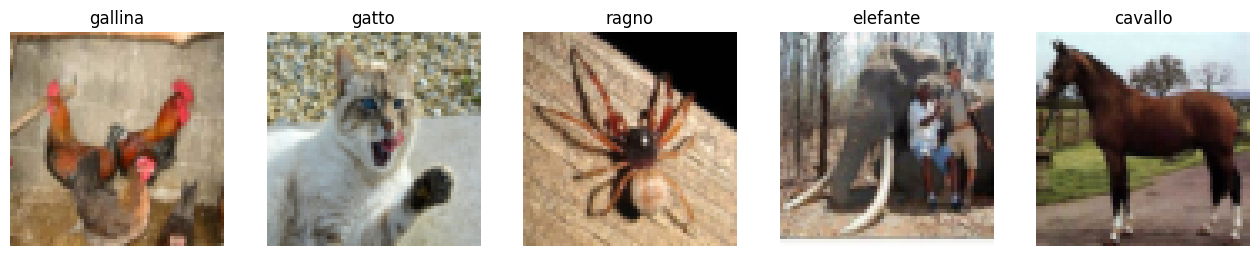

In [20]:
# Samples with data augmentation
view_dataloader_images(train_dataloader_animals,
                       animals_class_names,
                       n=5)

## Create models and setup experiments

In [21]:
from torchinfo import summary

In [22]:
# Create epoch list
num_epochs = [30]

# Set learning rate
lr = 0.001

### Animals model and experiments

In [31]:
from scripts import model

num_epochs = [50]

# General parameters
inp = 3
oup = len(animals_class_names)
#dropout = 0.3
#dropblock = 0.3

# Stock TinyVGG model
#model_animals = model.TinyVGG(input_shape=inp, output_shape=oup)
#model_animals_tvgg = model.TinyVGG(input_shape=inp, output_shape=oup)

# Slightly modified TinyVGG

# Stock AJ_CNN
model_animals = model.AJ_CNN(input_shape=3, output_shape=oup, hidden_units=12, dropout=0.3)

# Grid search, no aug
#model_animals = model.AJ_CNN(input_shape=3, output_shape=oup, hidden_units=12, dropout=0.4)

# Grid search, with aug
#model_animals = model.AJ_CNN(input_shape=3, output_shape=oup, hidden_units=12, dropout=0.4)

# Random search, no aug
#model_animals = model.AJ_CNN(input_shape=3, output_shape=oup, hidden_units=12, dropout=0.5)

# Random search, with aug
#model_animals = model.AJ_CNN(input_shape=3, output_shape=oup, hidden_units=12, dropout=0.1)

summary(model=model_animals,
        input_size=(1, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AJ_CNN (AJ_CNN)                          [1, 3, 64, 64]       [1, 5]               --                   True
├─Sequential (conv_block_1)              [1, 3, 64, 64]       [1, 12, 32, 32]      --                   True
│    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 12, 64, 64]      324                  True
│    └─BatchNorm2d (1)                   [1, 12, 64, 64]      [1, 12, 64, 64]      24                   True
│    └─ReLU (2)                          [1, 12, 64, 64]      [1, 12, 64, 64]      --                   --
│    └─MaxPool2d (3)                     [1, 12, 64, 64]      [1, 12, 32, 32]      --                   --
├─DropBlock2D (dropblock)                [1, 12, 32, 32]      [1, 12, 32, 32]      --                   --
├─Sequential (conv_block_2)              [1, 12, 32, 32]      [1, 24, 16, 16]      --                   True
│    └─Conv2d (0)   

In [32]:
# Create dataloaders dictionary for various dataloaders
train_dataloaders_animals = {
    #"no_aug": train_dataloader_animals,
    #"AutoAugment": train_dataloader_animals_AutoAugment,
    #"RandAugment": train_dataloader_animals_RandAugment,
    #"AugMix": train_dataloader_animals_AugMix,
    #"TrivialAugmentWide": train_dataloader_animals_TrivialAugmentWide,
    "ManualAugment": train_dataloader_animals_ManualAugment
                     }

### Confusion matrix, worst classes

In [33]:
%%script false --no-raise-error

from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_animals.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader_animals):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_animals(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader_animals])
test_truth

In [34]:
%%script false --no-raise-error

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy

# Assuming you have the number of classes stored in num_classes
num_classes = len(animals_class_names)

# Setup confusion matrix instance for multiclass classification
confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
confmat_tensor = confmat(preds=test_preds, target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=animals_class_names,
    figsize=(10, 7)
)

In [35]:
%%script false --no-raise-error

# Calculate the sum of true instances for each class
true_instances_per_class = confmat_tensor.sum(dim=1)

# Calculate the sum of misclassifications for each class
misclassifications_per_class = true_instances_per_class - confmat_tensor.diag()

# Calculate misclassification rates for each class
misclassification_rates = misclassifications_per_class / true_instances_per_class

# Find the index of the worst-performing classes
worst_classes_indices = misclassification_rates.argsort(descending=True)

# Get the class names corresponding to the worst classes
worst_classes_names = [animals_class_names[i] for i in worst_classes_indices]

# Print or use the worst classes
print("Worst-performing classes:")
for name in worst_classes_names:
    print(name)

### Dataloader testing and training

In [36]:
import numpy as np
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [37]:
%%time
#%%script false --no-raise-error

from scripts.utils import save_model
from scripts.engine import train
from lib.experiment_tracking import create_writer

# 1. Set the random seeds
#hf.set_seeds(seed=42)
#seed_everything(seed=42)
#seed_everything(seed=66)
#seed_everything(seed=13)
#seed_everything(seed=79)
#seed_everything(seed=20)

#seeds = [20]
#seeds = [79]
#seeds = [13]
#seeds = [66]
seeds = [42]

# 2. Keep track of experiment numbers
experiment_number = 0

# Loop through seeds
for seed in seeds:
    seed_everything(seed=seed)

    # 3. Loop through each DataLoader
    for dataloader_name, train_dataloader_animals in train_dataloaders_animals.items():

        # 4. Loop through each number of epochs
        for epochs in num_epochs: 
        
            model_name = model_animals.__class__.__name__

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = model_animals

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            #optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            #optimizer = torch.optim.SGD(params=model.parameters(), lr=4e-05)
            #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            
            # best results optimizer
            #optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
            #optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00034)
            #optimizer = torch.optim.SGD(model.parameters(), lr=0.00256)

            # 9. Train target model with target dataloaders and track experiments
            results = train(model=model,
                train_dataloader=train_dataloader_animals,
                dataloader_name=dataloader_name,
                test_dataloader=test_dataloader_animals,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                seed=seed,
                writer=create_writer(experiment_name=dataloader_name,
                                        model_name=model_name,
                                        extra=f"{epochs}_epochs"))
            
            test_acc = results.get("test_acc")[-1]
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"{experiment_number:04d}_{model_name}_{dataloader_name}_{epochs}_epochs_{test_acc}_test_acc.pth"
            save_model(model=model,
                        target_dir="models",
                        model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: AJ_CNN
[INFO] DataLoader: ManualAugment
[INFO] Number of epochs: 50
[INFO] Created SummaryWriter, saving to: runs/2024-01-18/ManualAugment/AJ_CNN/50_epochs...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3735 | train_acc: 0.4758 | test_loss: 1.1479 | test_acc: 0.5604 | lr: 0.00100000
Epoch: 2 | train_loss: 1.0908 | train_acc: 0.5901 | test_loss: 0.9750 | test_acc: 0.6676 | lr: 0.00100000
Epoch: 3 | train_loss: 0.9557 | train_acc: 0.6459 | test_loss: 0.9614 | test_acc: 0.6394 | lr: 0.00100000
Epoch: 4 | train_loss: 0.8912 | train_acc: 0.6737 | test_loss: 0.8752 | test_acc: 0.6910 | lr: 0.00100000
Epoch: 5 | train_loss: 0.8459 | train_acc: 0.6914 | test_loss: 0.9223 | test_acc: 0.6621 | lr: 0.00100000
Epoch: 6 | train_loss: 0.8082 | train_acc: 0.7057 | test_loss: 1.1384 | test_acc: 0.6025 | lr: 0.00100000
Epoch: 7 | train_loss: 0.7830 | train_acc: 0.7131 | test_loss: 0.8803 | test_acc: 0.6996 | lr: 0.00100000
Epoch: 8 | train_loss: 0.7398 | train_acc: 0.7328 | test_loss: 0.8367 | test_acc: 0.6887 | lr: 0.00100000
Epoch: 9 | train_loss: 0.7291 | train_acc: 0.7423 | test_loss: 0.8143 | test_acc: 0.7007 | lr: 0.00100000
Epoch: 10 | train_loss: 0.7255 | train_acc: 0.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs